# Bottom Up Casing Design - Part 2 - Automation

Created by Lukas Mosser, 2016

## Introduction
In part 1 of this series on casing design we developed a workflow to determine casing setting depths
from the following first principles:

1. Don't fracture the formation: Stay below the fracture gradient
2. Avoid an influx of fluids (kick): Stay above the pore pressure
3. Our data is uncertain: Add a safety margin.
4. Consider HSE

We then turned our theory into code and were able to compute the setting depths 
for each section of the wellbore.

In this tutorial we will automate this process by defining a simple class that
we can reuse in the future whenever we want to perform a casing design.

Important! Do not use this for real world applications! 
We have considerably simplified our approach by not including over and underpressured regimes.
See here for more information: [Casing Seat Depth - Part 1](notebooks/Casing Seat Depth Determination - Part 1.ipynb)

## Learning Outcomes

1. Moving a method to an external file
3. Using a while loop to perform an iterative computation

## Data Handling

As usual, let's load some data and have a look at it.

This time we have moved our code to display the graphics to another file.

Our notebook becomes a bit easier to view and read and we can reuse this part
of our notebooks in any other application where we want to display casing setting depths.

You can find the method **plot_casing_setting_depths** defined [here](casing_plot.py)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

#We import from our newly defined plotting library :)
from casing_plot import plot_casing_setting_depths

# And inline any graphics we want to display
%matplotlib inline 

In [2]:
fracture_pressure_data = np.loadtxt("data/fracture_pressure.csv", delimiter=",")
fracture_pressure, TVD_frac = fracture_pressure_data.T

pore_pressure_data = np.loadtxt("data/pore_pressure.csv", delimiter=",")
pore_pressure, TVD_pore = pore_pressure_data.T



Plotting our graph becomes as easy as pie, all we have to provide is an axis **ax** to plot our data on.

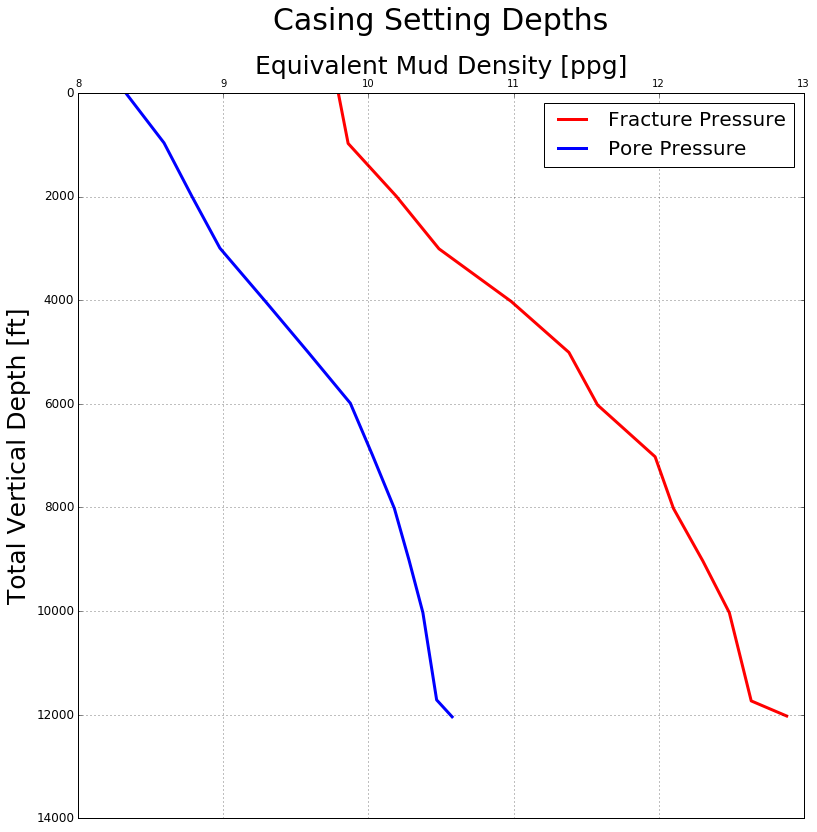

In [3]:
fig, ax = plt.subplots(1, figsize=(13, 13))

#We simply provide our data arrays to plot the data
plot_casing_setting_depths(ax, fracture_pressure, pore_pressure, TVD_frac, TVD_pore)

## Automating the casing seat procedure

Based on the first part of this series we will now turn our manual procedure into an automatic process.

We will start off by defining a new method that will give us the **mud weight and tvd** of the next casing section.
Last time we used numpy.interp to find the values where we intersect our fracture and pore presuure curves.

We will do the same here but wrap it up nicely into a new method **bottom_up_casing_seat**.
We want this method to return two values:

1. The mud weight required for the next casing section.
2. The depth at which we have to seat the casing.

In [4]:
def bottom_up_casing_seat(pore_pressure, fracture_pressure, tvd_pore, tvd_frac,
                          previous_section_mud_weight):
    """
    
    We provide our fracture and pore pressure data as well as their corresponding depth values.
    Finally all we need to know is the previous sections mud weight as this will determine
    the casing setting depth of the next section.
    
    pore_pressure, fracture_pressure, tvd_pore, tvd_frac are 1D arrays of values
    previous_section_mud_weight is a scalar or single value.
    
    """
    next_section_tvd = np.interp(previous_section_mud_weight, fracture_pressure, tvd_frac)
    next_section_mud_weight = np.interp(next_section_tvd, tvd_pore, pore_pressure)
    return next_section_mud_weight, next_section_tvd



Now that we have the inner workings, our method that determines a casing setting depth,
we want to automate this process.

We will create a new method **find_casing_seats** that will **call** our previous method **bottom_up_casing_seat**
to determine the setting depth in each section.

As this is a **bottom up** design we will start at the lower most value of pore pressure and depth.

Our method **find_casing_seats** should return to us the following:
1. An array of pairs of casing setting depths and corresponding mud weights.

In [5]:
def find_casing_seats(pore_pressure, fracture_pressure, tvd_pore, tvd_frac, 
                      maxiter=100):
    
    #We are all the way at the bottom, so let's get the last value in our data arrays
    #If in Python we ever want the last value of an array, we simply call array[-1]!
    current_mud_weight = pore_pressure[-1]
    current_depth = tvd_pore[-1]

    #We will want to store our casing seats in a new array that we later return to the user.
    casing_seats = []
    
    #Let's keep track of how many times we iterate, so we don't get lost in an endless loop.
    i = 0
    
    #As long as we haven't reached the surface (current_depth > 0.0), keep on going up! 
    #Unless we iterate too many times (i < maxiter), stop.
    while current_depth > 0.0 and i < maxiter:
        
        #Here we call our previous method to get the new mud weights and setting depths
        next_section_mud_weight, next_section_tvd = bottom_up_casing_seat(pore_pressure, fracture_pressure, 
                                                                          tvd_pore, tvd_frac, 
                                                                          current_mud_weight)
        
        #Let's add them to our results.
        casing_seats.append((next_section_tvd, next_section_mud_weight))

        #We've moved up in the world! So let's update our current values to reflect our new depth.
        current_depth, current_mud_weight = next_section_tvd, next_section_mud_weight
        
        #Finally increment i by one to make sure we don't end up in an endless loop.
        i += 1
    
    #Finished! Bring back our results!
    return casing_seats

### Safety First!

We have everything defined now, to start and compute our casing setting depths.


But remember, safety first! So we will add a safety margin of 3% to our fracture and pore pressures.

In [6]:
fracture_pressure_safety = 0.97*fracture_pressure
pore_pressure_safety = 1.03*pore_pressure

### Computing our setting depths

We will now compute our casing setting depths by calling our method **find_casing_seats**.

This will perform the following steps:


1. Set the mud weight to be equivalent to the deepest pore pressure (bottom up design).

2. Enter a while loop until we hit the surface (or end up in endless loop limbo)
    2. Get the next section mud weight and setting depth from **bottom_up_casing_seat**
    2. Update our results!
    2. Set our new values to the current status

3. End while loop and return our results.

In [7]:
from casing_plot import get_casing_seat_plot_data

casing_seats = find_casing_seats(pore_pressure_safety, fracture_pressure_safety, TVD_pore, TVD_frac)
casing_seats_tvd, casing_seats_ppg = get_casing_seat_plot_data(pore_pressure_safety, TVD_pore, casing_seats)
print casing_seats_tvd
print casing_seats_ppg

[12041.462260339593, 4635.437968681077, 4635.437968681077, 1586.6622345831938, 1586.6622345831938, 0.0]
[10.893760229935475, 10.893760229935475, 9.7571865219707, 9.7571865219707, 8.967687680000726, 8.967687680000726]


We've again used a helper method get_casing_seat_plot_data to restructure our data and make it simpler to plot.

Let's plot our data and see if we get good results...

This time we will again use **plot_casing_setting_depths** but we specify our casing seats and safety margins for 
plotting purposes.

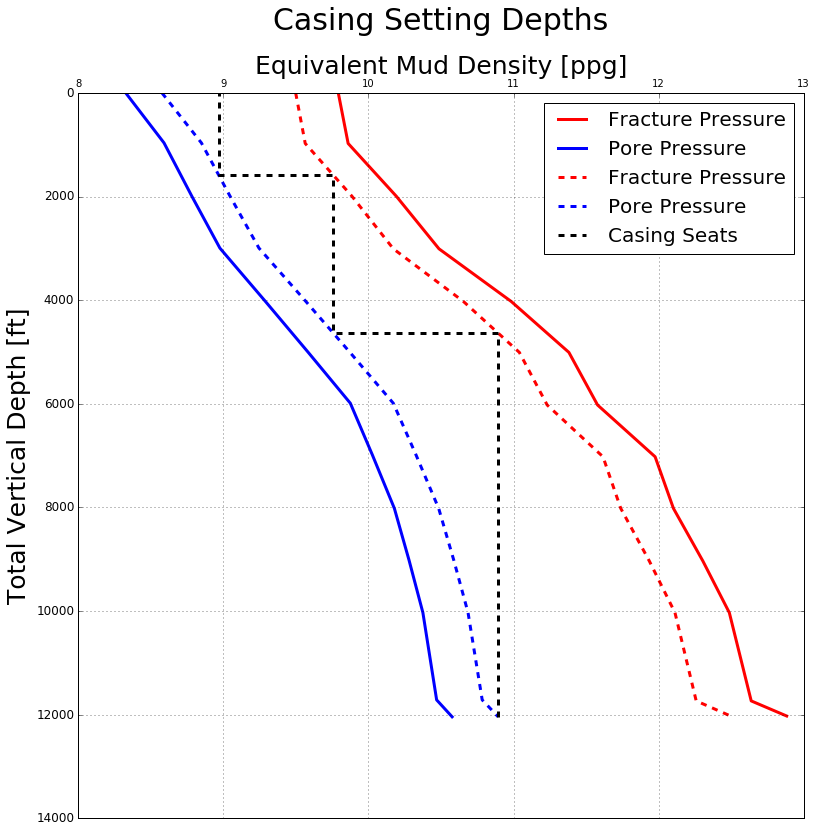

In [8]:
fig, ax = plt.subplots(1, figsize=(13, 13))
plot_casing_setting_depths(ax, fracture_pressure, pore_pressure, TVD_frac, TVD_pore,
                           fracture_pressure_safety=fracture_pressure_safety,
                           pore_pressure_safety=pore_pressure_safety,
                           casing_seats_ppg=casing_seats_ppg, casing_seats_tvd=casing_seats_tvd)

### Success!

Excellent! Our method returns the correct casing setting depth as expected for a bottom up casing design.

To recap and for future purposes all we have to do to compute our setting depths:

1. Load the pore pressure and fracture pressure data and their depth values.
2. Call **find_casing_seats**
3. (Optional) Restructure data for plotting
4. Plot our data or output to text file

Essentially our multi step procedure has become a three step procedure!

We have successfully automated the casing setting depth procedure for simple pressure vs. depth profiles.

### Next Up

Next time we will look at: 
1. How we can import our data from an excel file.
2. We will then perform the same bottom up casing desing.
3. And finally write our results back to our Excel file.

If you enjoyed this edition of these notebooks feel free to leave a comment on LinkedIn or a like and share with your colleagues and friends.